In [1]:
import datetime

import pandas as pd
import pandas_profiling as pdp
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgb
import optuna.integration.lightgbm as lgb_opt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## データロード

In [2]:
# 基本データのデータロード
train_2018_df = pd.read_csv('../data/input/train_2018.csv')
train_2017_df = pd.read_csv('../data/input/train_2017.csv')
train_2016_df = pd.read_csv('../data/input/train_2016.csv')
train_2018_df['year'] = 2018
train_2017_df['year'] = 2017
train_2016_df['year'] = 2016
test_df = pd.read_csv('../data/input/test.csv')
test_df['year'] = 2019
all_df = pd.concat([train_2016_df, train_2017_df, train_2018_df, test_df], axis = 0).reset_index(drop=True)

# 出場記録のデータロード
event_play_2018_df = pd.read_csv('../data/work/event_play_2018.csv')
event_play_2017_df = pd.read_csv('../data/work/event_play_2017.csv')
event_play_2016_df = pd.read_csv('../data/work/event_play_2016.csv')
event_play_2015_df = pd.read_csv('../data/work/event_play_2015.csv')
event_play_2018_df['year'] = 2019
event_play_2017_df['year'] = 2018
event_play_2016_df['year'] = 2017
event_play_2015_df['year'] = 2016
all_event_play_df = pd.concat([event_play_2018_df, event_play_2017_df, event_play_2016_df, event_play_2015_df], axis = 0).reset_index(drop=True)

In [3]:
# 出場記録データの結合
all_df = pd.merge(all_df, all_event_play_df, on=['year', 'team', 'name'], how='left')

In [4]:
# データ概要
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1902 entries, 0 to 1901
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1902 non-null   int64  
 1   team                   1902 non-null   object 
 2   No                     1902 non-null   float64
 3   name                   1902 non-null   object 
 4   time_played            1414 non-null   float64
 5   position               1902 non-null   object 
 6   birthdate              1902 non-null   object 
 7   height                 1902 non-null   float64
 8   weight                 1902 non-null   float64
 9   salary                 1902 non-null   object 
 10  nth_year               1902 non-null   float64
 11  is_youth               341 non-null    float64
 12  nationality            276 non-null    object 
 13  j1_total_num_played    1640 non-null   float64
 14  j1_total_scores        1554 non-null   float64
 15  j2_t

### 特徴量エンジニアリング

#### name

In [5]:
# nameのlabelencoding
le = LabelEncoder()
le = le.fit(all_df['name'])
all_df['name'] = le.transform(all_df['name'])

#### team

In [6]:
# teamはprevX_teamと同値のencodingを実施するため、辞書を作成
# 出現回数が1のものは同値でencodingを実施
# prevX_teamのencodingでも利用
team_dic = {}

tmp_dic = pd.concat([all_df['team'], all_df['prev3_team'], all_df['prev2_team'], all_df['prev1_team']]).value_counts().to_dict()
tmp_list = sorted(tmp_dic.items(), key = lambda x:x[1])

label = 0
for i, j in tmp_list:
    if j == 1:
        team_dic[i] = label
    else:
        team_dic[i] = label
        label += 1

# teamのlabelencoding
all_df['team'] = all_df['team'].map(team_dic)

#### potision

In [7]:
# potisionのlabelencoding
le = LabelEncoder()
le = le.fit(all_df['position'])
all_df['position'] = le.transform(all_df['position'])

#### birthdate

In [8]:
# 生年月日より生まれ年を抽出
all_df['birthdate'] = pd.to_datetime(all_df['birthdate'])
all_df['birthdate_year'] = all_df['birthdate'].dt.year

#### salary

In [9]:
# salaryのNaN→中央値補完
med_salary = all_df[all_df['salary'] != '-']['salary'].median()
all_df['salary'] = all_df['salary'].mask(all_df['salary'] == '-', med_salary)
all_df['salary'] = all_df['salary'].astype(float)

#### is_youth

In [10]:
# is_youthのboolean変換
all_df['is_youth'] = all_df['is_youth'].notnull()

#### nationality

In [11]:
# nationalityのNaN→Japan補完
all_df['nationality'] = all_df['nationality'].fillna('japan')

# nationalityのlabelencoding
le = LabelEncoder()
le = le.fit(all_df['nationality'])
all_df['nationality'] = le.transform(all_df['nationality'])

#### prevX_transferred

In [12]:
# prevX_teamに'・'が含まれているかで移籍有無を抽出
for col, new_col in {'prev3_team':'prev3_transferred', 'prev2_team':'prev2_transferred', 'prev1_team':'prev1_transferred',}.items():
    all_df[new_col] = all_df[col].str.contains('-')

#### prevX_team

In [13]:
# 作成した辞書を用いてprevX_teamのlabelencoding
for col in ['prev3_team', 'prev2_team', 'prev1_team']:
    all_df[col] = all_df[col].map(team_dic)

#### prevX_div

In [14]:
# prevX_divの'-'→0補完
for col in ['prev3_div', 'prev2_div', 'prev1_div']:
    all_df[col] = all_df[col].replace('-', 0).astype(int)

#### prevX_num_played

In [15]:
# prevX_num_playedの'-'→NaN補完
for col in ['prev3_num_played', 'prev2_num_played', 'prev1_num_played']:
    all_df[col] = all_df[col].replace('-', np.nan).astype(float)

#### prevX_scores

In [16]:
# prevX_scoresの'-'→NaN補完
for col in ['prev3_scores', 'prev2_scores', 'prev1_scores']:
    all_df[col] = all_df[col].replace('-', np.nan).astype(float)

#### prevX_time_played

In [17]:
# prevX_time_playedの'-'→NaN補完
for col in ['prev3_time_played', 'prev2_time_played', 'prev1_time_played']:
    all_df[col] = all_df[col].replace('-', np.nan).astype(float)

### 学習

In [18]:
# 前処理後データ概要
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1902 entries, 0 to 1901
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     1902 non-null   int64         
 1   team                   1902 non-null   int64         
 2   No                     1902 non-null   float64       
 3   name                   1902 non-null   int32         
 4   time_played            1414 non-null   float64       
 5   position               1902 non-null   int32         
 6   birthdate              1902 non-null   datetime64[ns]
 7   height                 1902 non-null   float64       
 8   weight                 1902 non-null   float64       
 9   salary                 1902 non-null   float64       
 10  nth_year               1902 non-null   float64       
 11  is_youth               1902 non-null   bool          
 12  nationality            1902 non-null   int32         
 13  j1_

In [19]:
# 教師, 検証データ
x_train_valid_df = all_df[all_df['year'] < 2019]
y_train_valid_df = x_train_valid_df['time_played']

# バリデーション
# x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid_df, y_train_valid_df, test_size=0.33, random_state=0, stratify = x_train_valid_df['year'])
x_train = x_train_valid_df[x_train_valid_df['year'] < 2018]
y_train = x_train['time_played']
x_valid = x_train_valid_df[x_train_valid_df['year'] == 2018]
y_valid = x_valid['time_played']

# テストデータ
test = all_df[all_df['year'] == 2019]

In [20]:
# 入力する特徴量
features = [
    'team',
    'position',
    'height',
    'weight',
    'salary',
    'nth_year',
    'is_youth',
    'nationality',
    'birthdate_year',
    'year',
    'j1_total_num_played',
    'j1_total_scores',
    'j2_total_num_played',
    'j2_total_scores',
    'j3_total_num_played',
    'j3_total_scores',
    'na_total_num_played',
    'na_total_scores',
    'prev3_transferred',
    'prev2_transferred',
    'prev1_transferred',
    'prev3_team',
    'prev2_team',
    'prev1_team',
    'prev3_div',
    'prev2_div',
    'prev1_div', 
    'prev3_num_played',
    'prev2_num_played',
    'prev1_num_played', 
    'prev3_scores',
    'prev2_scores',
    'prev1_scores', 
    'prev3_time_played',
    'prev2_time_played',
    'prev1_time_played',
    'rat_full_play',
    'rat_out_play',
    'rat_in_play', 
    'rat_inout_play',
    'rat_bench_play',
    'rat_susp_play',
    'rat_full_play_first',
    'rat_out_play_first',
    'rat_in_play_first',
    'rat_inout_play_first',
    'rat_bench_play_first',
    'rat_susp_play_first',
    'rat_full_play_second',
    'rat_out_play_second',
    'rat_in_play_second',
    'rat_inout_play_second',
    'rat_bench_play_second',
    'rat_susp_play_second'
]

In [21]:
# カテゴリ変数
categorical_features = ['team', 'position', 'nationality', 'prev3_team', 'prev2_team', 'prev1_team', 'prev3_div', 'prev2_div', 'prev1_div']

In [22]:
# lightgbmパラメータ
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_seed' : 0
}

In [23]:
# lightGBM用のデータセットを作成
lgb_train = lgb_opt.Dataset(x_train[features], y_train, categorical_feature = categorical_features, free_raw_data=False)
lgb_eval = lgb_opt.Dataset(x_valid[features], y_valid, categorical_feature = categorical_features, free_raw_data=False)

# モデルの作成
evals_result = {}
best_params = {}
model = lgb_opt.train(params = lgb_params,
                      train_set = lgb_train,
                      valid_sets = [lgb_train, lgb_eval],
                      categorical_feature = categorical_features,
                      verbose_eval = 10,
                      num_boost_round = 1000,
                      early_stopping_rounds = 20
)

# ベストパラメータの出力
best_params = model.params
print('=====Params======')
for key, value in best_params.items():
    print("  {}: {}".format(key, value))

# モデル精度の表示
valid_pred = model.predict(x_valid[features])
model_score = np.sqrt(metrics.mean_squared_error(valid_pred, y_valid))
print('=====Val score======')
print('  Val rmse score is {model_score}.'.format(model_score = model_score))

# テストデータの予測
y_pred = model.predict(test[features])

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 677.243	valid_1's rmse: 842.635
[20]	training's rmse: 540.262	valid_1's rmse: 823.866
[30]	training's rmse: 445.061	valid_1's rmse: 828.753
[40]	training's rmse: 377.49	valid_1's rmse: 834.585
Early stopping, best iteration is:
[21]	training's rmse: 528.252	valid_1's rmse: 822.537


feature_fraction, val_score: 822.536690:  14%|######1                                    | 1/7 [00:00<00:00,  8.14it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 680.821	valid_1's rmse: 841.024
[20]	training's rmse: 541.628	valid_1's rmse: 819.458
[30]	training's rmse: 450.482	valid_1's rmse: 823.305
[40]	training's rmse: 383.35	valid_1's rmse: 832.231
Early stopping, best iteration is:
[23]	training's rmse: 510.541	valid_1's rmse: 817.517


feature_fraction, val_score: 817.517136:  29%|############2                              | 2/7 [00:00<00:00,  8.57it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 684.813	valid_1's rmse: 845.076
[20]	training's rmse: 546.232	valid_1's rmse: 821.943
[30]	training's rmse: 456.068	valid_1's rmse: 828.23
[40]	training's rmse: 392.248	valid_1's rmse: 828.774
Early stopping, best iteration is:
[22]	training's rmse: 526.101	valid_1's rmse: 819.453


feature_fraction, val_score: 817.517136:  43%|##################4                        | 3/7 [00:00<00:00,  8.57it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 688.038	valid_1's rmse: 847.49
[20]	training's rmse: 550.673	valid_1's rmse: 827.477
[30]	training's rmse: 461.035	valid_1's rmse: 831.821
[40]	training's rmse: 399.965	valid_1's rmse: 835.923
Early stopping, best iteration is:
[23]	training's rmse: 521.051	valid_1's rmse: 826.554


feature_fraction, val_score: 817.517136:  57%|########################5                  | 4/7 [00:00<00:00,  9.06it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 674.195	valid_1's rmse: 834.815
[20]	training's rmse: 533.158	valid_1's rmse: 814.426
[30]	training's rmse: 438.062	valid_1's rmse: 820.204
[40]	training's rmse: 369.934	valid_1's rmse: 822.497
Early stopping, best iteration is:
[20]	training's rmse: 533.158	valid_1's rmse: 814.426


feature_fraction, val_score: 814.425851:  71%|##############################7            | 5/7 [00:00<00:00,  9.06it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 673.808	valid_1's rmse: 837.775
[20]	training's rmse: 531.295	valid_1's rmse: 826.761
[30]	training's rmse: 434.281	valid_1's rmse: 833.331
Early stopping, best iteration is:
[16]	training's rmse: 580.375	valid_1's rmse: 826.695


feature_fraction, val_score: 814.425851:  86%|####################################8      | 6/7 [00:00<00:00,  9.44it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 693.957	valid_1's rmse: 847.413
[20]	training's rmse: 562.744	valid_1's rmse: 826.674
[30]	training's rmse: 475.638	valid_1's rmse: 828.998
[40]	training's rmse: 411.693	valid_1's rmse: 831.408
Early stopping, best iteration is:
[21]	training's rmse: 553.218	valid_1's rmse: 824.279


num_leaves, val_score: 814.425851:   0%|                                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 775.639	valid_1's rmse: 851.722
[20]	training's rmse: 698.837	valid_1's rmse: 827.155
[30]	training's rmse: 654.348	valid_1's rmse: 823.673
[40]	training's rmse: 619.505	valid_1's rmse: 823.564
[50]	training's rmse: 593.716	valid_1's rmse: 822.933
[60]	training's rmse: 569.821	valid_1's rmse: 821.626
Early stopping, best iteration is:
[44]	training's rmse: 609.239	valid_1's rmse: 821.115


num_leaves, val_score: 814.425851:   5%|##4                                             | 1/20 [00:00<00:02,  9.18it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  10%|####8                                           | 2/20 [00:00<00:02,  7.75it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  15%|#######2                                        | 3/20 [00:00<00:02,  7.61it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  20%|#########6                                      | 4/20 [00:00<00:02,  7.33it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  25%|############                                    | 5/20 [00:00<00:02,  7.20it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  30%|##############4                                 | 6/20 [00:00<00:01,  7.21it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  35%|################7                               | 7/20 [00:00<00:01,  7.18it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  40%|###################2                            | 8/20 [00:01<00:02,  5.70it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  45%|#####################6                          | 9/20 [00:01<00:01,  6.00it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  50%|#######################5                       | 10/20 [00:01<00:01,  6.22it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  55%|#########################8                     | 11/20 [00:01<00:01,  6.49it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  60%|############################2                  | 12/20 [00:01<00:01,  6.54it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 670.211	valid_1's rmse: 843.639
[20]	training's rmse: 529.048	valid_1's rmse: 822.78
[30]	training's rmse: 431.013	valid_1's rmse: 823.103
[40]	training's rmse: 359.223	valid_1's rmse: 827.269
Early stopping, best iteration is:
[24]	training's rmse: 486.247	valid_1's rmse: 820.599


num_leaves, val_score: 814.425851:  65%|##############################5                | 13/20 [00:01<00:01,  6.58it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  70%|################################9              | 14/20 [00:02<00:00,  6.05it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  75%|###################################2           | 15/20 [00:02<00:00,  6.10it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  80%|#####################################6         | 16/20 [00:02<00:00,  6.39it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 747.987	valid_1's rmse: 846.493
[20]	training's rmse: 653.114	valid_1's rmse: 825.315
[30]	training's rmse: 594.908	valid_1's rmse: 825.303
[40]	training's rmse: 551.792	valid_1's rmse: 835.573
Early stopping, best iteration is:
[25]	training's rmse: 623.067	valid_1's rmse: 823.844


num_leaves, val_score: 814.425851:  85%|#######################################9       | 17/20 [00:02<00:00,  6.39it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  90%|##########################################3    | 18/20 [00:02<00:00,  6.97it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


num_leaves, val_score: 814.425851:  95%|############################################6  | 19/20 [00:02<00:00,  6.98it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 668.416	valid_1's rmse: 842.938
[20]	training's rmse: 525.102	valid_1's rmse: 820.426
[30]	training's rmse: 425.767	valid_1's rmse: 822.27
[40]	training's rmse: 354.987	valid_1's rmse: 829.088
Early stopping, best iteration is:
[24]	training's rmse: 482.115	valid_1's rmse: 816.939


bagging, val_score: 814.425851:   0%|                                                           | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 677.537	valid_1's rmse: 836.857
[20]	training's rmse: 536.877	valid_1's rmse: 813.777
[30]	training's rmse: 442.621	valid_1's rmse: 823.43
[40]	training's rmse: 373.471	valid_1's rmse: 832.528
Early stopping, best iteration is:
[20]	training's rmse: 536.877	valid_1's rmse: 813.777


bagging, val_score: 813.777419:  10%|#####1                                             | 1/10 [00:00<00:01,  7.05it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.967	valid_1's rmse: 832.105
[20]	training's rmse: 535.874	valid_1's rmse: 814.054
[30]	training's rmse: 442.183	valid_1's rmse: 814.524
Early stopping, best iteration is:
[19]	training's rmse: 548.907	valid_1's rmse: 812.519


bagging, val_score: 812.518731:  20%|##########2                                        | 2/10 [00:00<00:01,  7.34it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 678.354	valid_1's rmse: 834.07
[20]	training's rmse: 534.803	valid_1's rmse: 818.052
[30]	training's rmse: 442.301	valid_1's rmse: 827.398
Early stopping, best iteration is:
[18]	training's rmse: 557.162	valid_1's rmse: 816.279


bagging, val_score: 812.518731:  30%|###############3                                   | 3/10 [00:00<00:00,  7.72it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 675.713	valid_1's rmse: 848.446
[20]	training's rmse: 537.468	valid_1's rmse: 829.755
[30]	training's rmse: 440.084	valid_1's rmse: 836.024
[40]	training's rmse: 372.694	valid_1's rmse: 843.138
Early stopping, best iteration is:
[20]	training's rmse: 537.468	valid_1's rmse: 829.755


bagging, val_score: 812.518731:  40%|####################4                              | 4/10 [00:00<00:00,  7.61it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 679.032	valid_1's rmse: 840.955
[20]	training's rmse: 536.65	valid_1's rmse: 825.565
[30]	training's rmse: 442.661	valid_1's rmse: 833.833
Early stopping, best iteration is:
[18]	training's rmse: 559.593	valid_1's rmse: 824.938


bagging, val_score: 812.518731:  50%|#########################5                         | 5/10 [00:00<00:00,  7.74it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.032	valid_1's rmse: 847.5
[20]	training's rmse: 535.24	valid_1's rmse: 829.936
[30]	training's rmse: 446.162	valid_1's rmse: 834.786
[40]	training's rmse: 379.181	valid_1's rmse: 848.91
Early stopping, best iteration is:
[23]	training's rmse: 505.452	valid_1's rmse: 829.135


bagging, val_score: 812.518731:  60%|##############################6                    | 6/10 [00:00<00:00,  7.40it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 758.604	valid_1's rmse: 842.613
[20]	training's rmse: 674.785	valid_1's rmse: 824.74
[30]	training's rmse: 621.27	valid_1's rmse: 822.604
[40]	training's rmse: 592.287	valid_1's rmse: 824.583
Early stopping, best iteration is:
[26]	training's rmse: 641.183	valid_1's rmse: 819.823


bagging, val_score: 812.518731:  70%|###################################6               | 7/10 [00:00<00:00,  7.88it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.022	valid_1's rmse: 834.516
[20]	training's rmse: 536.711	valid_1's rmse: 809.122
[30]	training's rmse: 440.68	valid_1's rmse: 807.082
[40]	training's rmse: 370.763	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.828	valid_1's rmse: 805.937


bagging, val_score: 805.936798:  80%|########################################8          | 8/10 [00:01<00:00,  7.75it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 696.07	valid_1's rmse: 837.621
[20]	training's rmse: 567.82	valid_1's rmse: 816.265
[30]	training's rmse: 485.728	valid_1's rmse: 821.306
Early stopping, best iteration is:
[18]	training's rmse: 591.648	valid_1's rmse: 812.414


bagging, val_score: 805.936798:  90%|#############################################9     | 9/10 [00:01<00:00,  7.97it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 704.693	valid_1's rmse: 843.302
[20]	training's rmse: 576.464	valid_1's rmse: 821.579
[30]	training's rmse: 493.606	valid_1's rmse: 826.79
[40]	training's rmse: 434.188	valid_1's rmse: 837.034
Early stopping, best iteration is:
[21]	training's rmse: 565.545	valid_1's rmse: 820.586


feature_fraction_stage2, val_score: 805.936798:   0%|                                            | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 678.36	valid_1's rmse: 839.932
[20]	training's rmse: 539.772	valid_1's rmse: 819.877
[30]	training's rmse: 444.598	valid_1's rmse: 827.216
[40]	training's rmse: 375.77	valid_1's rmse: 829.325
Early stopping, best iteration is:
[21]	training's rmse: 528.688	valid_1's rmse: 818.055


feature_fraction_stage2, val_score: 805.936798:  17%|######                              | 1/6 [00:00<00:00,  8.93it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 674.178	valid_1's rmse: 842.564
[20]	training's rmse: 531.145	valid_1's rmse: 826.414
[30]	training's rmse: 441.719	valid_1's rmse: 830.352
Early stopping, best iteration is:
[19]	training's rmse: 541.85	valid_1's rmse: 826.325


feature_fraction_stage2, val_score: 805.936798:  33%|############                        | 2/6 [00:00<00:00,  9.08it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 677.677	valid_1's rmse: 834.399
[20]	training's rmse: 535.504	valid_1's rmse: 819.015
[30]	training's rmse: 441.23	valid_1's rmse: 815.697
[40]	training's rmse: 375.116	valid_1's rmse: 819.383
Early stopping, best iteration is:
[24]	training's rmse: 493.303	valid_1's rmse: 814.861


feature_fraction_stage2, val_score: 805.936798:  50%|##################                  | 3/6 [00:00<00:00,  8.91it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.55	valid_1's rmse: 842.462
[20]	training's rmse: 534.013	valid_1's rmse: 828.508
[30]	training's rmse: 444.634	valid_1's rmse: 834.212
[40]	training's rmse: 379.338	valid_1's rmse: 837.438
Early stopping, best iteration is:
[24]	training's rmse: 494.772	valid_1's rmse: 826.606


feature_fraction_stage2, val_score: 805.936798:  67%|########################            | 4/6 [00:00<00:00,  8.64it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 674.207	valid_1's rmse: 843.2
[20]	training's rmse: 534.468	valid_1's rmse: 826.495
[30]	training's rmse: 440.807	valid_1's rmse: 830.538
Early stopping, best iteration is:
[19]	training's rmse: 545.025	valid_1's rmse: 826.239


feature_fraction_stage2, val_score: 805.936798:  83%|##############################      | 5/6 [00:00<00:00,  8.75it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.022	valid_1's rmse: 834.516
[20]	training's rmse: 536.711	valid_1's rmse: 809.122
[30]	training's rmse: 440.68	valid_1's rmse: 807.082
[40]	training's rmse: 370.763	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.828	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936798:   0%|                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.028	valid_1's rmse: 834.518
[20]	training's rmse: 536.717	valid_1's rmse: 809.122
[30]	training's rmse: 440.687	valid_1's rmse: 807.082
[40]	training's rmse: 370.77	valid_1's rmse: 815.614
Early stopping, best iteration is:
[23]	training's rmse: 504.835	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936636:   5%|#8                                  | 1/20 [00:00<00:02,  7.52it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 675.543	valid_1's rmse: 834.69
[20]	training's rmse: 534.991	valid_1's rmse: 812.92
[30]	training's rmse: 437.635	valid_1's rmse: 815.21
[40]	training's rmse: 371.984	valid_1's rmse: 817.831
Early stopping, best iteration is:
[25]	training's rmse: 481.464	valid_1's rmse: 811.373


regularization_factors, val_score: 805.936636:  10%|###6                                | 2/20 [00:00<00:02,  7.56it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.028	valid_1's rmse: 834.518
[20]	training's rmse: 536.718	valid_1's rmse: 809.122
[30]	training's rmse: 440.688	valid_1's rmse: 807.082
[40]	training's rmse: 370.771	valid_1's rmse: 815.614
Early stopping, best iteration is:
[23]	training's rmse: 504.836	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  15%|#####3                              | 3/20 [00:00<00:02,  7.60it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 675.544	valid_1's rmse: 834.69
[20]	training's rmse: 534.992	valid_1's rmse: 812.92
[30]	training's rmse: 437.635	valid_1's rmse: 815.209
[40]	training's rmse: 371.984	valid_1's rmse: 817.831
Early stopping, best iteration is:
[25]	training's rmse: 481.464	valid_1's rmse: 811.373


regularization_factors, val_score: 805.936624:  20%|#######2                            | 4/20 [00:00<00:02,  7.51it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.027	valid_1's rmse: 834.518
[20]	training's rmse: 536.717	valid_1's rmse: 809.122
[30]	training's rmse: 440.687	valid_1's rmse: 807.082
[40]	training's rmse: 370.769	valid_1's rmse: 815.614
Early stopping, best iteration is:
[23]	training's rmse: 504.835	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  25%|#########                           | 5/20 [00:00<00:01,  7.51it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.024	valid_1's rmse: 834.517
[20]	training's rmse: 536.714	valid_1's rmse: 809.122
[30]	training's rmse: 440.683	valid_1's rmse: 807.082
[40]	training's rmse: 370.766	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.831	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  30%|##########7                         | 6/20 [00:00<00:01,  7.50it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.024	valid_1's rmse: 834.517
[20]	training's rmse: 536.714	valid_1's rmse: 809.122
[30]	training's rmse: 440.683	valid_1's rmse: 807.082
[40]	training's rmse: 370.766	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.831	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  35%|############6                       | 7/20 [00:00<00:01,  7.61it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.025	valid_1's rmse: 834.517
[20]	training's rmse: 536.714	valid_1's rmse: 809.122
[30]	training's rmse: 440.684	valid_1's rmse: 807.082
[40]	training's rmse: 370.766	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.832	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  40%|##############4                     | 8/20 [00:01<00:01,  7.71it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.024	valid_1's rmse: 834.517
[20]	training's rmse: 536.714	valid_1's rmse: 809.122
[30]	training's rmse: 440.683	valid_1's rmse: 807.082
[40]	training's rmse: 370.766	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.832	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  45%|################2                   | 9/20 [00:01<00:01,  7.69it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.024	valid_1's rmse: 834.517
[20]	training's rmse: 536.714	valid_1's rmse: 809.122
[30]	training's rmse: 440.683	valid_1's rmse: 807.082
[40]	training's rmse: 370.766	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.832	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  50%|#################5                 | 10/20 [00:01<00:01,  7.55it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.025	valid_1's rmse: 834.518
[20]	training's rmse: 536.715	valid_1's rmse: 809.122
[30]	training's rmse: 440.684	valid_1's rmse: 807.082
[40]	training's rmse: 370.767	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.832	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  55%|###################2               | 11/20 [00:01<00:01,  7.56it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.026	valid_1's rmse: 834.518
[20]	training's rmse: 536.716	valid_1's rmse: 809.122
[30]	training's rmse: 440.685	valid_1's rmse: 807.082
[40]	training's rmse: 370.768	valid_1's rmse: 815.614
Early stopping, best iteration is:
[23]	training's rmse: 504.833	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  60%|#####################              | 12/20 [00:01<00:01,  7.57it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.788	valid_1's rmse: 830.674
[20]	training's rmse: 532.729	valid_1's rmse: 810.813
[30]	training's rmse: 440.588	valid_1's rmse: 815.459
[40]	training's rmse: 371.769	valid_1's rmse: 821.483
Early stopping, best iteration is:
[25]	training's rmse: 482.114	valid_1's rmse: 810.404


regularization_factors, val_score: 805.936624:  65%|######################7            | 13/20 [00:01<00:00,  7.60it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 675.579	valid_1's rmse: 834.702
[20]	training's rmse: 535.03	valid_1's rmse: 812.92
[30]	training's rmse: 437.677	valid_1's rmse: 815.205
[40]	training's rmse: 372.028	valid_1's rmse: 817.825
Early stopping, best iteration is:
[25]	training's rmse: 481.504	valid_1's rmse: 811.37


regularization_factors, val_score: 805.936624:  70%|########################5          | 14/20 [00:01<00:00,  7.56it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.022	valid_1's rmse: 834.516
[20]	training's rmse: 536.711	valid_1's rmse: 809.122
[30]	training's rmse: 440.68	valid_1's rmse: 807.082
[40]	training's rmse: 370.763	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.828	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  75%|##########################2        | 15/20 [00:01<00:00,  7.65it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.022	valid_1's rmse: 834.516
[20]	training's rmse: 536.711	valid_1's rmse: 809.122
[30]	training's rmse: 440.68	valid_1's rmse: 807.082
[40]	training's rmse: 370.763	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.828	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  80%|############################       | 16/20 [00:02<00:00,  7.61it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.022	valid_1's rmse: 834.517
[20]	training's rmse: 536.711	valid_1's rmse: 809.122
[30]	training's rmse: 440.68	valid_1's rmse: 807.082
[40]	training's rmse: 370.763	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.829	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  85%|#############################7     | 17/20 [00:02<00:00,  7.49it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 675.678	valid_1's rmse: 834.733
[20]	training's rmse: 535.136	valid_1's rmse: 812.921
[30]	training's rmse: 437.792	valid_1's rmse: 815.193
[40]	training's rmse: 372.149	valid_1's rmse: 817.809
Early stopping, best iteration is:
[25]	training's rmse: 481.615	valid_1's rmse: 811.363


regularization_factors, val_score: 805.936624:  90%|###############################5   | 18/20 [00:02<00:00,  7.46it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 676.022	valid_1's rmse: 834.517
[20]	training's rmse: 536.712	valid_1's rmse: 809.122
[30]	training's rmse: 440.681	valid_1's rmse: 807.082
[40]	training's rmse: 370.763	valid_1's rmse: 815.615
Early stopping, best iteration is:
[23]	training's rmse: 504.829	valid_1's rmse: 805.937


regularization_factors, val_score: 805.936624:  95%|#################################2 | 19/20 [00:02<00:00,  7.53it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 675.555	valid_1's rmse: 834.694
[20]	training's rmse: 535.003	valid_1's rmse: 812.92
[30]	training's rmse: 437.648	valid_1's rmse: 815.208
[40]	training's rmse: 371.998	valid_1's rmse: 817.829
Early stopping, best iteration is:
[25]	training's rmse: 481.476	valid_1's rmse: 811.372


min_data_in_leaf, val_score: 805.936624:   0%|                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 749.271	valid_1's rmse: 842.693
[20]	training's rmse: 655.685	valid_1's rmse: 819.817
[30]	training's rmse: 593.93	valid_1's rmse: 823.2
[40]	training's rmse: 549.618	valid_1's rmse: 824.027
Early stopping, best iteration is:
[21]	training's rmse: 649.067	valid_1's rmse: 819.378


min_data_in_leaf, val_score: 805.936624:  20%|########6                                  | 1/5 [00:00<00:00, 10.01it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 784.107	valid_1's rmse: 851.848
[20]	training's rmse: 714.607	valid_1's rmse: 821.866
[30]	training's rmse: 674.159	valid_1's rmse: 816.107
[40]	training's rmse: 645.652	valid_1's rmse: 815.061
[50]	training's rmse: 621.071	valid_1's rmse: 817.691
Early stopping, best iteration is:
[35]	training's rmse: 657.956	valid_1's rmse: 814.099


min_data_in_leaf, val_score: 805.936624:  40%|#################2                         | 2/5 [00:00<00:00, 11.84it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 699.594	valid_1's rmse: 841.518
[20]	training's rmse: 566.947	valid_1's rmse: 823.368
[30]	training's rmse: 480.417	valid_1's rmse: 824.035
[40]	training's rmse: 416.787	valid_1's rmse: 828.246
Early stopping, best iteration is:
[22]	training's rmse: 547.158	valid_1's rmse: 821.077


min_data_in_leaf, val_score: 805.936624:  60%|#########################8                 | 3/5 [00:00<00:00, 10.48it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 646.909	valid_1's rmse: 838.421
[20]	training's rmse: 489.781	valid_1's rmse: 823.876
[30]	training's rmse: 391.77	valid_1's rmse: 828.142
[40]	training's rmse: 321.589	valid_1's rmse: 836.151
Early stopping, best iteration is:
[24]	training's rmse: 446.475	valid_1's rmse: 821.603


min_data_in_leaf, val_score: 805.936624:  80%|##################################4        | 4/5 [00:00<00:00,  9.07it/s]

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 638.47	valid_1's rmse: 843.18
[20]	training's rmse: 476.98	valid_1's rmse: 826.484
[30]	training's rmse: 375.371	valid_1's rmse: 829.187
[40]	training's rmse: 306.147	valid_1's rmse: 835.635
Early stopping, best iteration is:
[23]	training's rmse: 443.402	valid_1's rmse: 823.278


min_data_in_leaf, val_score: 805.936624: 100%|###########################################| 5/5 [00:00<00:00,  8.24it/s]


=====Params======
  objective: regression
  metric: rmse
  random_seed: 0
  lambda_l1: 0.008073102326596698
  lambda_l2: 0.0011120041362558182
  num_leaves: 31
  feature_fraction: 0.8999999999999999
  bagging_fraction: 0.9947254986351809
  bagging_freq: 2
  min_child_samples: 20
=====Val score======
  Val rmse score is 806.9167774509904.


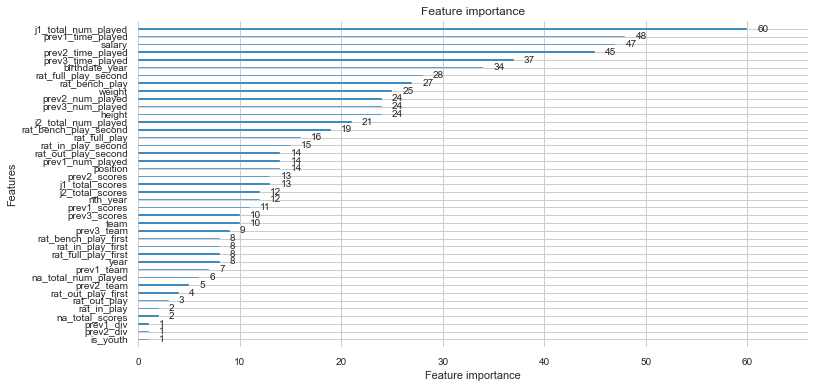

In [24]:
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

### 出力

In [25]:
# 提出用データの作成
sub = test[['id', 'time_played']].copy()
sub['time_played'] = y_pred

# csvの出力
now = datetime.datetime.now()
sub_name = '特徴量追加(event_play)'
file_name = '../data/output/sub_' + sub_name + '_' + now.strftime('%Y%m%d_%H%M%S') + '.csv'
sub.to_csv(file_name, index=False)